# Gender study

In [ ]:
import random
from pathlib import Path
import numpy as np
import pickle
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.4) # for label size

In [87]:
# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [3]:
SEED = 2021
set_seed(seed=SEED)

Random seed 2021 has been set.


In [4]:
# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [5]:
device = set_device()

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu


In [6]:
nma_drive = Path(".")
abide_path = Path(nma_drive / "ABIDE_pcp")

In [104]:
corr_harmo = np.load(nma_drive / "correlation_mat_harmo_whole.npy")
corr_harmo.shape

(871, 200, 200)

In [8]:
# Load the dataset from the drive
with open(nma_drive / "abide_pcp_whole.pkl", "rb") as f:
    abide = pickle.load(f)
# abide    

In [9]:
phen_abide = abide['phenotypic']
phen_abide

,i,Unnamed: 0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
1,1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
3,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1
5,5,6,50007,6,50007,PITT,Pitt_0050007,1,1,17.78,...,NaN,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,1107,1108,51583,1108,51583,SBL,SBL_0051583,1,2,35.00,...,NaN,OK,NaN,OK,ic-cerebellum-temporal_lobe,OK,NaN,OK,NaN,0
1108,1108,1109,51584,1109,51584,SBL,SBL_0051584,1,2,49.00,...,NaN,OK,NaN,maybe,vmpfc dropout,OK,NaN,OK,NaN,0
1109,1109,1110,51585,1110,51585,SBL,SBL_0051585,1,1,27.00,...,NaN,OK,NaN,maybe,ic-cerebellum-temporal_lobe,OK,NaN,OK,NaN,0
1110,1110,1111,51606,1111,51606,MAX_MUN,MaxMun_a_0051606,1,2,29.00,...,NaN,OK,NaN,maybe,ic-cerebellum,OK,NaN,OK,NaN,0


In [10]:
def equal_len(corr_mat): 

    a_dims = np.array([item.shape for item in corr_mat])

    rois_dim = np.max(a_dims[:, 1])
    ts_dim = np.max(a_dims[:, 0])

    x_data = np.zeros((ts_dim, rois_dim, len(corr_mat)))

    for idx, val in enumerate(corr_mat):
        x_data[0:val.shape[0], 0:val.shape[1], idx] = val

    return x_data

def gender_selection(phen_abide, corr_harmo, y_target): 

    '''
    :param phen_abide: phenotypic Pandas Dataframe extracted at the beggining of the notebook

    :param corr_harmo: correlation matrix array with the whole dataset - harmonized

    :param y_target: y_target array with vales [1,0]

    :return: X_data, y_target for male and female respectively
    
    '''

    # new_indices = np.arange(0, 172, 1)
    new_indices = np.arange(0, len(phen_abide), 1)

    idx_phen_abide = phen_abide.set_index(new_indices)

    males_stat = idx_phen_abide[idx_phen_abide['SEX'] == 1]
    males_index = np.array(males_stat.index)

    females_stat = idx_phen_abide[idx_phen_abide['SEX'] == 2]
    females_index = np.array(females_stat.index)

    males_data = corr_harmo[males_index]
    females_data = corr_harmo[females_index]

    print(f'Male harmonized matrix: {males_data.shape}, Female harmonized matrix: {females_data.shape}')

    #rois_dim = np.max(a_dims[:, 1])
    dx_data_males = y_target[males_index]
    dx_data_females = y_target[females_index]

    # Equal series length

    x_data_males = equal_len(males_data)
    x_data_females = equal_len(females_data)

    print(f'Final X_data shape from males: {x_data_males.shape}, Final X_data shape from females: {x_data_females.shape}')

    return x_data_males, dx_data_males, x_data_females, dx_data_females

In [11]:
a_dims = np.array([item.shape for item in abide['rois_cc200']])
rois_dim = np.max(a_dims[:, 1])
ts_dim = np.max(a_dims[:, 0])
a_dims.shape, rois_dim, ts_dim

((871, 2), 200, 316)

In [12]:
x_data = np.zeros((ts_dim, rois_dim, len(abide['rois_cc200'])))
for idx, val in enumerate(abide['rois_cc200']):
    x_data[0:val.shape[0], 0:val.shape[1], idx] = val
x_data.shape

(316, 200, 871)

In [13]:
dx_counts = phen_abide['DX_GROUP']
y_target = np.array(dx_counts)
print(y_target, len(y_target), type(y_target))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 1 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 1 2
 2 1 1 2 2 1 1 1 1 1 2 2 1 2 1 2 1 1 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 1 1 1 1 

In [14]:
def replace_values(input_list):
    output_list = [0 if x == 1 else 1 if x == 2 else x for x in input_list]
    return np.array(output_list)

In [15]:
y_target = replace_values(y_target)
print(y_target, len(y_target))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1
 1 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 0 0 0 0 

In [44]:
x_data_males, dx_data_males, x_data_females, dx_data_females = gender_selection(phen_abide, corr_harmo, y_target)
x_data_males.shape, dx_data_males.shape, x_data_females.shape, dx_data_females.shape

Male harmonized matrix: (727, 200, 200), Female harmonized matrix: (144, 200, 200)
Final X_data shape from males: (200, 200, 727), Final X_data shape from females: (200, 200, 144)


((200, 200, 727), (727,), (200, 200, 144), (144,))

In [59]:
def shuffle_and_split_data(X, y, seed):
  """
  Helper function to shuffle and split incoming data

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  torch.manual_seed(seed)

  X = np.asarray(X)
  # Number of samples
  N = X.shape[2]
  # print(N)
    
  # Shuffle data
  shuffled_indices = torch.randperm(N)  # Get indices to shuffle data, could use torch.randperm
  X = X[:, :, shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(0.2 * N)    # Assign test datset size using 20% of samples
  X_test = X[:, :, :test_size]
  y_test = y[:test_size]
  X_train = X[:, :, test_size:]
  y_train = y[test_size:]

  return torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float(), torch.from_numpy(X_train), torch.from_numpy(y_train)
    

## Females only

In [74]:
x_data_females.shape, dx_data_females.shape

((200, 200, 144), (144,))

In [75]:
X_test, y_test, X_train, y_train = shuffle_and_split_data(x_data_females, dx_data_females, seed=SEED)
X_test.shape, y_test.shape, X_train.shape, y_train.shape

(torch.Size([200, 200, 28]),
 torch.Size([28]),
 torch.Size([200, 200, 116]),
 torch.Size([116]))

In [78]:
def X_train_test_reshape(X_train, X_test):
    # Convertir X_train a una matriz de dos dimensiones (8, 200*200)
    X_train = X_train.reshape(X_train.shape[2], -1)
    print(X_train.shape)
    # Convertir X_test a una matriz de dos dimensiones (2, 200*200)
    X_test = X_test.reshape(X_test.shape[2], -1)
    print(X_test.shape)
    return X_train, X_test

In [79]:
X_train, X_test = X_train_test_reshape(X_train, X_test)

torch.Size([116, 40000])
torch.Size([28, 40000])


In [80]:
X_train.shape, y_train.shape

(torch.Size([116, 40000]), torch.Size([116]))

In [81]:
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

batch_size = 32
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=0,
                         worker_init_fn=seed_worker,
                         generator=g_seed)


train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True,
                          shuffle=True, num_workers=0,
                          worker_init_fn=seed_worker,
                          generator=g_seed)

In [82]:
print(X_test.shape, y_test.shape, X_train.shape, y_train.shape)

torch.Size([28, 40000]) torch.Size([28]) torch.Size([116, 40000]) torch.Size([116])


In [83]:
class Net(nn.Module):
  """
  Initialize MLP Network
  """

  def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
    """
    Initialize MLP Network parameters

    Args:
      actv: string
        Activation function
      input_feature_num: int
        Number of input features
      hidden_unit_nums: list
        Number of units in the hidden layer
      output_feature_num: int
        Number of output features

    Returns:
      Nothing
    """
    super(Net, self).__init__()
    self.input_feature_num = input_feature_num # Save the input size for reshaping later
    self.mlp = nn.Sequential() # Initialize layers of MLP

    in_num = input_feature_num # Initialize the temporary input feature to each layer
    for i in range(len(hidden_unit_nums)): # Loop over layers and create each one

      out_num = hidden_unit_nums[i] # Assign the current layer hidden unit from list
      layer = nn.Linear(in_num, out_num) # Use nn.Linear to define the layer
      in_num = out_num # Assign next layer input using current layer output
      self.mlp.add_module('Linear_%d'%i, layer) # Append layer to the model with a name

      actv_layer = eval('nn.%s'%actv) # Assign activation function (eval allows us to instantiate object from string)
      self.mlp.add_module('Activation_%d'%i, actv_layer) # Append activation to the model with a name

    out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

  def forward(self, x):
    """
    Simulate forward pass of MLP Network

    Args:
      x: torch.tensor
        Input data

    Returns:
      logits: Instance of MLP
        Forward pass of MLP
    """
    # Reshape inputs to (batch_size, input_feature_num)
    # Just in case the input vector is not 2D, like an image!
    x = x.view(-1, self.input_feature_num)

    logits = self.mlp(x) # Forward pass of MLP
    return logits


In [84]:
def train_test_classification(net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=1, verbose=True,
                              training_plot=False, device='cpu'):
  """
  Accumulate training loss/Evaluate performance

  Args:
    net: instance of Net class
      Describes the model with ReLU activation, batch size 128
    criterion: torch.nn type
      Criterion combines LogSoftmax and NLLLoss in one single class.
    optimizer: torch.optim type
      Implements Adam algorithm.
    train_loader: torch.utils.data type
      Combines the train dataset and sampler, and provides an iterable over the given dataset.
    test_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.
    num_epochs: int
      Number of epochs [default: 1]
    verbose: boolean
      If True, print statistics
    training_plot=False
      If True, display training plot
    device: string
      CUDA/GPU if available, CPU otherwise

  Returns:
    Nothing
  """
  net.train()
  training_losses = []
  for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      # Get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      # Zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)

      # print(outputs, type(outputs), outputs.shape)
      # print(labels.shape, type(labels), labels)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Print statistics
      if verbose:
        training_losses += [loss.item()]

  net.eval()

  def test(data_loader):
    """
    Function to gauge network performance

    Args:
      data_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.

    Returns:
      acc: float
        Performance of the network
      total: int
        Number of datapoints in the dataloader
    """
    correct = 0
    total = 0
    precision = []
    recall = []
    F1 = []
    balanced_acc = []
    for data in data_loader:
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.cpu().long()

      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      predicted = predicted.cpu()
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      precision.append(metrics.precision_score(labels,predicted))
      recall.append(metrics.recall_score(labels,predicted))
      F1.append(metrics.f1_score(labels,predicted))
      balanced_acc.append(metrics.balanced_accuracy_score(labels, predicted))

    acc = 100 * correct / total
    return total, acc, precision, recall, F1, balanced_acc, predicted, labels

  train_total, train_acc, precision_train, recall_train, F1_train,balanced_acc, y_pred_train, y_true_train = test(train_loader)
  test_total, test_acc, precision_test, recall_test, F1_test, balanced_acc_test, y_pred_test, y_true_test = test(test_loader)

  if verbose:
    print(f"Accuracy on the {train_total} training samples: {train_acc:0.2f}")
    print(f"Accuracy on the {test_total} testing samples: {test_acc:0.2f}")
    
    # More metrics
    print(f"Balanced accuracy on training {balanced_acc}, on testing samples: {balanced_acc_test}"),
    print(f"Precision training {precision_train} testing samples: {precision_test}"),
    print(f"Recall training {recall_train} Recall testing samples: {recall_test}"),
    print(f"F1 training {F1_train} F1 testing samples: {F1_test}"),
    # print('TRAINING Y: ', y_pred_train, y_true_train),
    # print('TESTING Y: ', y_pred_test, y_true_test),
    cnf_mat_train = metrics.confusion_matrix(y_pred_train, y_true_train)
    cnf_mat_test = metrics.confusion_matrix(y_pred_test, y_true_test)
    fig1, ax1 = plt.subplots()
    df_cm = pd.DataFrame(cnf_mat_train, range(2), range(2))
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="crest") # font size
    plt.title('Confusion Matrix Train',fontsize=16)
    plt.show()
    fig2,ax2 = plt.subplots()
    df_cm = pd.DataFrame(cnf_mat_test, range(2), range(2))
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="crest") # font size
    plt.title('Confusion Matrix Test',fontsize=16)
    plt.show()

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.title('Loss Function')
    plt.show()

  return train_acc, test_acc, training_losses

Random seed 2021 has been set.


  0%|          | 0/150 [00:00<?, ?it/s]

Accuracy on the 96 training samples: 100.00
Accuracy on the 28 testing samples: 60.71
Balanced accuracy on training [1.0, 1.0, 1.0], on testing samples: [0.5]
Precision training [1.0, 1.0, 1.0] testing samples: [0.6071428571428571]
Recall training [1.0, 1.0, 1.0] Recall testing samples: [1.0]
F1 training [1.0, 1.0, 1.0] F1 testing samples: [0.7555555555555554]


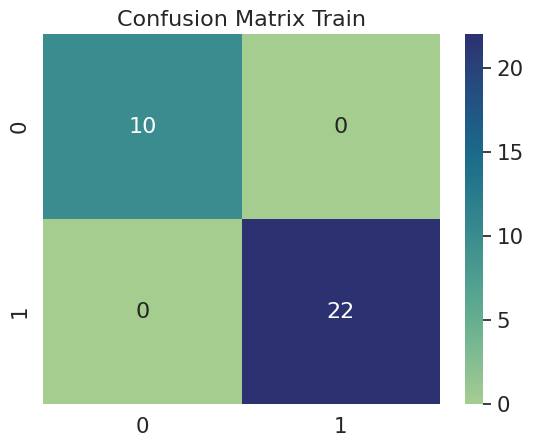

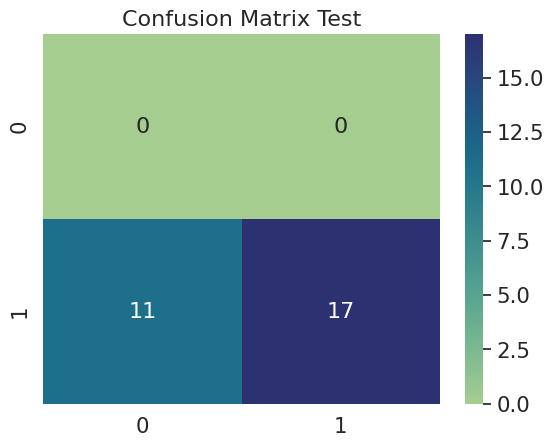

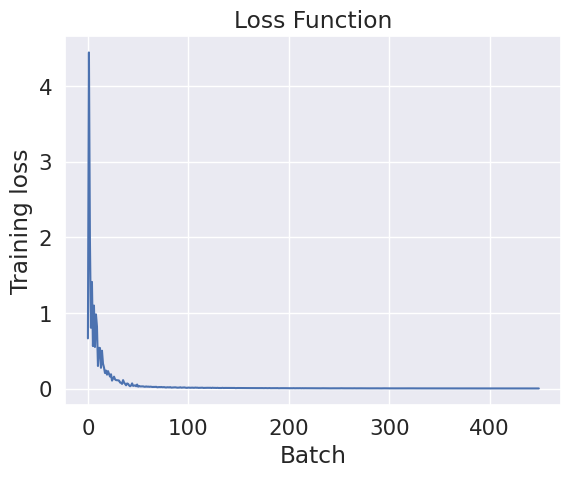

In [92]:
set_seed(SEED)
net = Net('ReLU()', X_train.shape[1], [32], 2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 150

_, _, training_losses = train_test_classification(net, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=device)

## Males only

In [93]:
x_data_males.shape, dx_data_males.shape

((200, 200, 727), (727,))

In [94]:
X_test, y_test, X_train, y_train = shuffle_and_split_data(x_data_males, dx_data_males, seed=SEED)
X_test.shape, y_test.shape, X_train.shape, y_train.shape

(torch.Size([200, 200, 145]),
 torch.Size([145]),
 torch.Size([200, 200, 582]),
 torch.Size([582]))

In [95]:
X_train, X_test = X_train_test_reshape(X_train, X_test)

torch.Size([582, 40000])
torch.Size([145, 40000])


In [96]:
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

batch_size = 32
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=0,
                         worker_init_fn=seed_worker,
                         generator=g_seed)


train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True,
                          shuffle=True, num_workers=0,
                          worker_init_fn=seed_worker,
                          generator=g_seed)

Random seed 2021 has been set.


  0%|          | 0/150 [00:00<?, ?it/s]

Accuracy on the 576 training samples: 51.91
Accuracy on the 145 testing samples: 52.41
Balanced accuracy on training [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], on testing samples: [0.5, 0.5, 0.5, 0.5, 0.5]
Precision training [0.53125, 0.34375, 0.5, 0.40625, 0.5, 0.5, 0.5, 0.53125, 0.5, 0.5625, 0.59375, 0.5625, 0.625, 0.5625, 0.59375, 0.625, 0.5, 0.40625] testing samples: [0.5625, 0.34375, 0.625, 0.625, 0.4117647058823529]
Recall training [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] Recall testing samples: [1.0, 1.0, 1.0, 1.0, 1.0]
F1 training [0.6938775510204082, 0.5116279069767442, 0.6666666666666666, 0.5777777777777777, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6938775510204082, 0.6666666666666666, 0.72, 0.7450980392156863, 0.72, 0.7692307692307693, 0.72, 0.7450980392156863, 0.7692307692307693, 0.6666666666666666, 0.5777777777777777] F1 testing samples: [0.72, 0.51162790

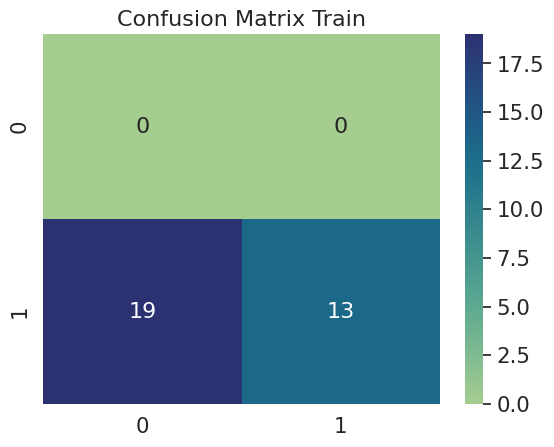

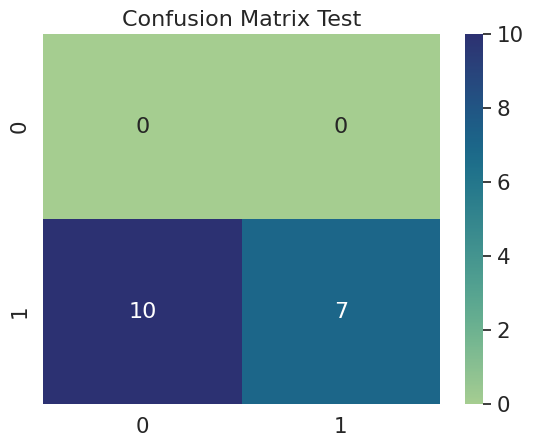

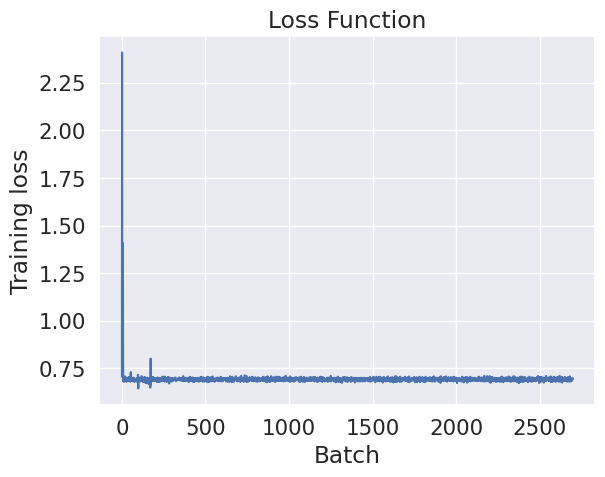

In [97]:
set_seed(SEED)
net = Net('ReLU()', X_train.shape[1], [32], 2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 150

_, _, training_losses = train_test_classification(net, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=device)

## Train on males+females - test on females

In [119]:
corr_harmo.shape

(871, 200, 200)

In [120]:
x_data_swaped = np.swapaxes(corr_harmo, 0, -1)

In [121]:
x_data_swaped.shape, y_target.shape

((200, 200, 871), (871,))

In [122]:
x_data_females.shape, dx_data_females.shape

((200, 200, 144), (144,))

In [130]:
X_test = torch.from_numpy(x_data_females).float()
y_test = torch.from_numpy(dx_data_females).float()
X_train = torch.from_numpy(x_data_swaped).float()
y_train = torch.from_numpy(y_target).float()
X_test.shape, y_test.shape, X_train.shape, y_train.shape

(torch.Size([200, 200, 144]),
 torch.Size([144]),
 torch.Size([200, 200, 871]),
 torch.Size([871]))

In [131]:
X_train, X_test = X_train_test_reshape(X_train, X_test)

torch.Size([871, 40000])
torch.Size([144, 40000])


In [132]:
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

batch_size = 32
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=0,
                         worker_init_fn=seed_worker,
                         generator=g_seed)


train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True,
                          shuffle=True, num_workers=0,
                          worker_init_fn=seed_worker,
                          generator=g_seed)

Random seed 2021 has been set.


  0%|          | 0/150 [00:00<?, ?it/s]

Accuracy on the 864 training samples: 100.00
Accuracy on the 144 testing samples: 56.25
Balanced accuracy on training [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], on testing samples: [0.5833333333333333, 0.5367965367965368, 0.53125, 0.5742857142857143, 0.3333333333333333]
Precision training [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] testing samples: [0.631578947368421, 0.6842105263157895, 0.5217391304347826, 0.8181818181818182, 0.5]
Recall training [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] Recall testing samples: [0.6666666666666666, 0.6190476190476191, 0.75, 0.72, 0.5]
F1 training [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

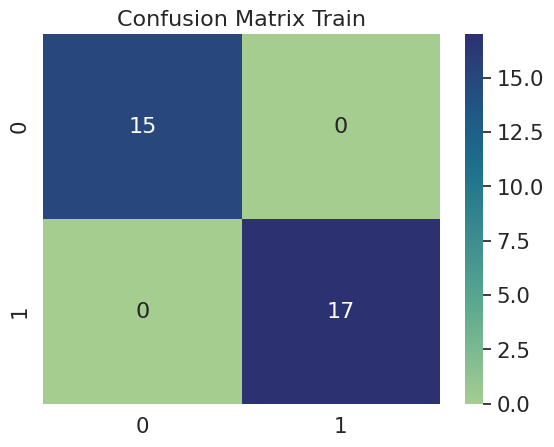

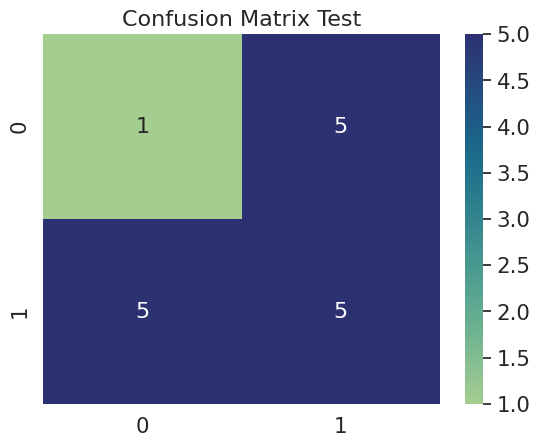

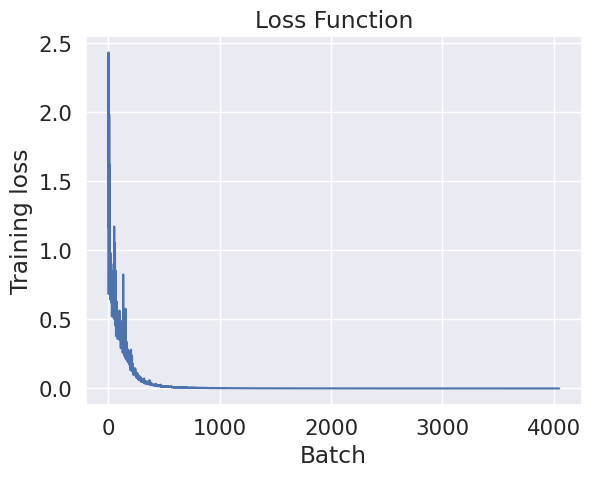

In [133]:
set_seed(SEED)
net = Net('ReLU()', X_train.shape[1], [32], 2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 150

_, _, training_losses = train_test_classification(net, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=device)